# Conditional Variational Autoencoder (CVAE)

In order to run a simulation, we need some type of function modeling the image $X$ from the wealth $y$. What better way to get such a function than modelling the actual DHS data? To do this, I'm training a Conditional Variational Autoencoder. The result is far from perfect, but I believe it is better than defining a function "manually".

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()

RANDOM_STATE = 42
N_COMPONENTS = 232

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data():

    # Read config file
    config = configparser.ConfigParser()
    config.read('../config.ini')

    DATA_DIR = config['PATHS']['DATA_DIR']

    #embeddings = np.load(os.path.join(DATA_DIR, 'small_ssl4eo_resnet50.npy'))
    #df = pd.read_csv(os.path.join(DATA_DIR, 'small_dhs.csv'))
    
    embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
    df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

    assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'
    
    X = embeddings

    # Cheat by doing rescaling and PCA on the whole set
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components=N_COMPONENTS)
    X = pca.fit_transform(X)

    y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
    y = y.clip(0, 1)

    X = torch.tensor(X, dtype=torch.float).cuda()
    y = torch.tensor(y, dtype=torch.float).cuda()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
    #X_cal, X_val, y_cal, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=RANDOM_STATE)
    
    #return X_train, X_val, X_cal, X_test, y_train, y_val, y_cal, y_test
    return X_train, X_val, X_test, y_train.unsqueeze(1), y_val.unsqueeze(1), y_test.unsqueeze(1)

# Load data
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# -------------------
# CVAE Model
# -------------------
class CVAE(nn.Module):
    def __init__(self, input_dim=232, condition_dim=1, latent_dim=16, hidden_dim=128):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # Output X'
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample Z"""
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std

    def forward(self, x, y):
        """Forward pass through CVAE"""
        # Encode X and Y
        enc_input = torch.cat([x, y], dim=1)  # Concatenate X with Y
        h = self.encoder(enc_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)  # Sample latent variable

        # Decode Z and Y
        dec_input = torch.cat([z, y], dim=1)  # Concatenate Z with Y
        x_recon = self.decoder(dec_input)

        return x_recon, mu, logvar

In [4]:
# -------------------
# Training
# -------------------
def loss_function(x_recon, x, mu, logvar):
    """Loss = Reconstruction Loss + KL Divergence"""
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_loss

# Initialize model
latent_dim = 32  # Small latent space to regularize learning
model = CVAE(input_dim=X_train.shape[1], latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1000
batch_size = 512

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

best_model = model.state_dict()
best_loss = np.inf

pbar = tqdm(range(epochs))
for epoch in pbar:
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch, y_batch)
        loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        x_recon, mu, logvar = model(X_val, y_val)
        val_loss = loss_function(x_recon, X_val, mu, logvar).item()
        
    # Save best model
    if val_loss < best_loss:
        best_model = model.state_dict()
        best_loss = val_loss
    
    pbar.set_postfix({'Loss': f'{total_loss / len(dataloader):.4f}', 'Val. loss': f'{val_loss:.4f}'})
    #print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}, Val Loss: {val_loss:.4f}")
model.load_state_dict(best_model)

100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s, Loss=5.6876, Val. loss=5.7854]


<All keys matched successfully>

In [5]:
# -------------------
# Generate num_samples New Samples for a Given Y
# -------------------
def generate_trial_samples(y_input, num_samples=5):
    model.eval()
    y_input = torch.tensor(y_input, dtype=torch.float32).to(device)

    with torch.no_grad():
        z = torch.randn((num_samples, latent_dim)).to(device)  # Sample random latent vectors
        dec_input = torch.cat([z, y_input.repeat(num_samples, 1)], dim=1)  # Concatenate Z with Y
        generated_X = model.decoder(dec_input).cpu().numpy()
    
    return generated_X

# Example: Generate new X samples for Y = 0.5
new_Y = np.array([[0.5]])  # Example target value
new_samples = generate_trial_samples(new_Y, num_samples=5)
print("Generated Samples for Y=0.5:", new_samples)

Generated Samples for Y=0.5: [[-8.2917509e+00  2.0538688e+00 -2.2636712e+00 ...  9.1291964e-04
  -1.9166484e-02  3.5399698e-02]
 [-8.0876436e+00  2.0712337e+00 -9.9629009e-01 ...  4.8243850e-03
   6.1013550e-03  1.2486776e-02]
 [ 2.3038719e+00 -2.2115417e+01 -1.5079520e+01 ... -1.9042313e-02
   3.8404912e-02  9.8195530e-02]
 [-9.3913221e+00  3.9169238e+00 -1.2244400e+00 ...  7.2019249e-03
  -2.2399083e-02  1.2608236e-02]
 [-6.4984875e+00 -9.1959167e-01 -6.3116395e-01 ...  4.3649524e-03
  -4.6161421e-02  2.4604527e-02]]


## Evaluate

In [6]:
# -------------------
# Generate New Samples for a Given Y
# -------------------
def generate_samples(y_input):
    model.eval()
    # y_input = torch.tensor(y_input, dtype=torch.float32).to(device)

    with torch.no_grad():
        z = torch.randn((len(y_input), latent_dim)).to(device)  # Sample random latent vectors
        dec_input = torch.cat([z, y_input], dim=1)  # Concatenate Z with Y
        generated_X = model.decoder(dec_input).cpu().numpy()
    
    return generated_X

X_gen = generate_samples(y_test)

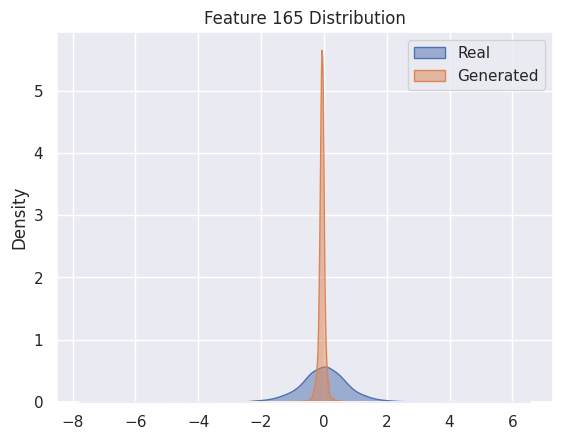

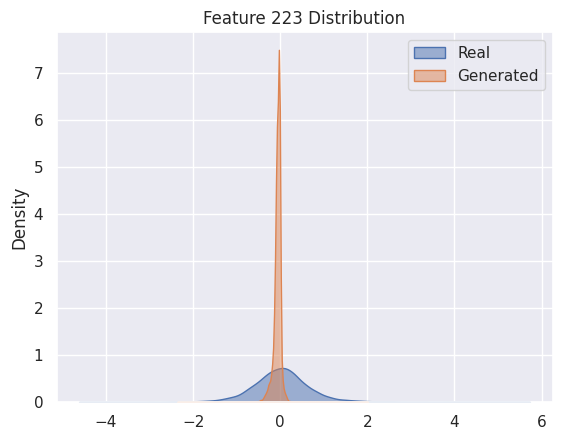

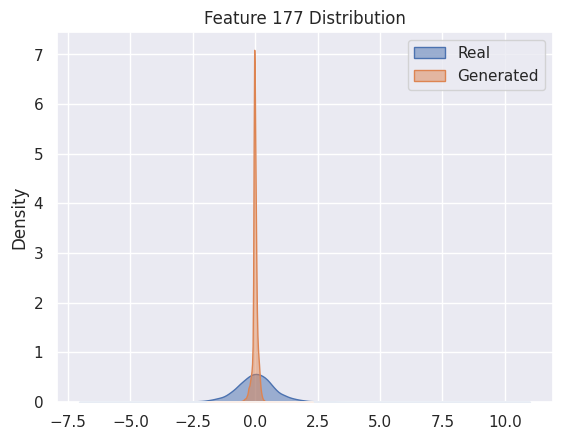

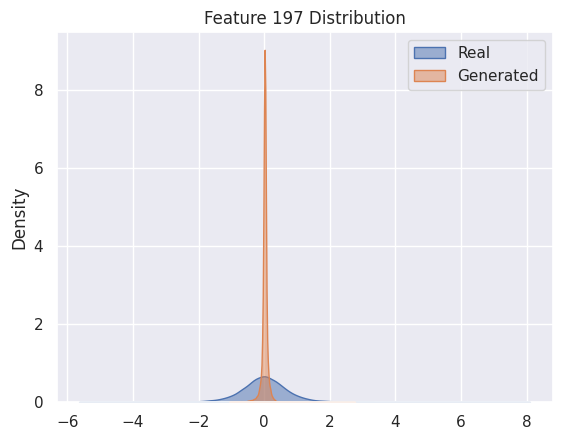

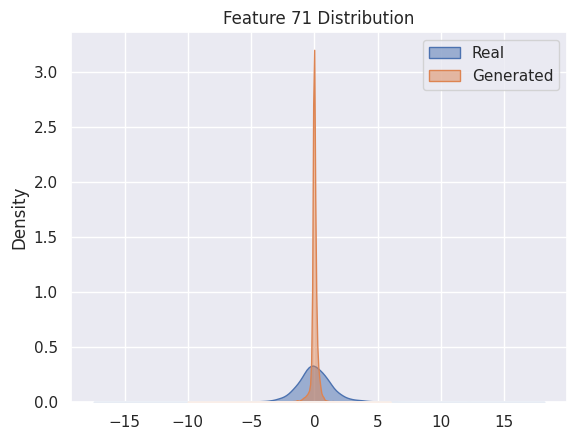

In [7]:
import seaborn as sns

def compare_distributions(real_X, generated_X):
    """Compares the distribution of real vs. generated data for a few features"""
    feature_idx = np.random.randint(0, real_X.shape[1], 5)  # Randomly pick 5 features

    for idx in feature_idx:
        sns.kdeplot(real_X[:, idx], label="Real", fill=True, alpha=0.5)
        sns.kdeplot(generated_X[:, idx], label="Generated", fill=True, alpha=0.5)
        plt.title(f"Feature {idx} Distribution")
        plt.legend()
        plt.show()
        
compare_distributions(X_test.cpu().numpy(), X_gen)

As we can see, the model does not capture all the variance of the distribution

(13724,)


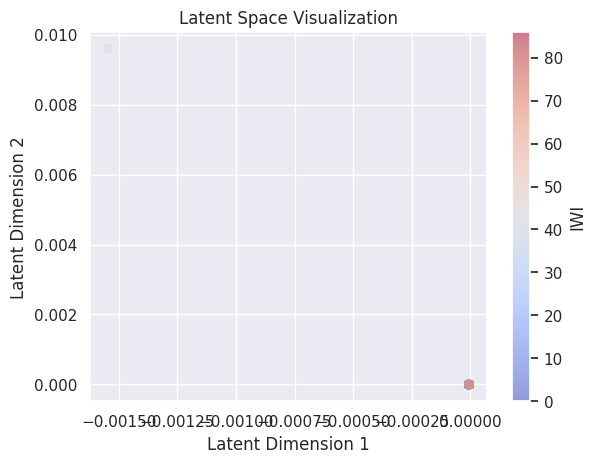

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_latent_space(model, X_test, Y_test):
    """Projects latent space into 2D using PCA"""
    model.eval()
    X_test, Y_test = X_test.to(device), Y_test.to(device)

    with torch.no_grad():
        enc_input = torch.cat([X_test, Y_test], dim=1)
        latent_means = model.fc_mu(model.encoder(enc_input)).cpu().numpy()  # Extract latent vectors

    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_means)
    
    p = (latent_2d[:, 0] < 0.01) #+ (latent_2d[:, 0])
    p = p #> 1
    print(p.shape)
    plt.scatter(latent_2d[:, 0][p], latent_2d[:, 1][p], c=100*Y_test[p].cpu().numpy().flatten(), cmap="coolwarm", alpha=0.5)
    plt.colorbar(label="IWI")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

plot_latent_space(model, X_test, y_test)

The encodings do capture some information about wealth though.

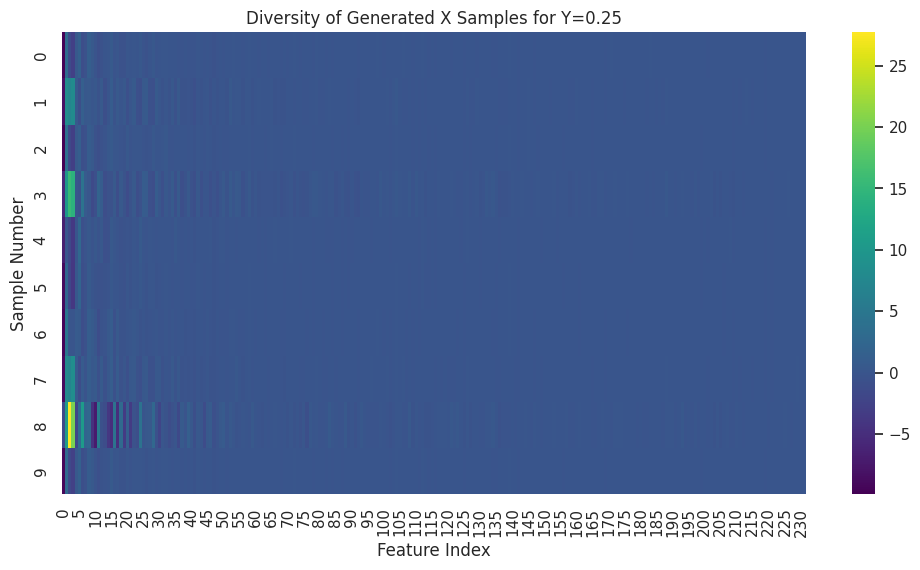

In [9]:
import seaborn as sns

def visualize_sample_diversity(model, y_value, num_samples=10):
    """Generates multiple X samples for the same Y and visualizes variation"""
    generated_X = generate_trial_samples(np.array([[y_value]]), num_samples=num_samples)
    
    # Plot the first few dimensions to see diversity
    plt.figure(figsize=(12, 6))
    sns.heatmap(generated_X[:10], cmap="viridis", annot=False)
    plt.xlabel("Feature Index")
    plt.ylabel("Sample Number")
    plt.title(f"Diversity of Generated X Samples for Y={y_value}")
    plt.show()

visualize_sample_diversity(model, 0.25)

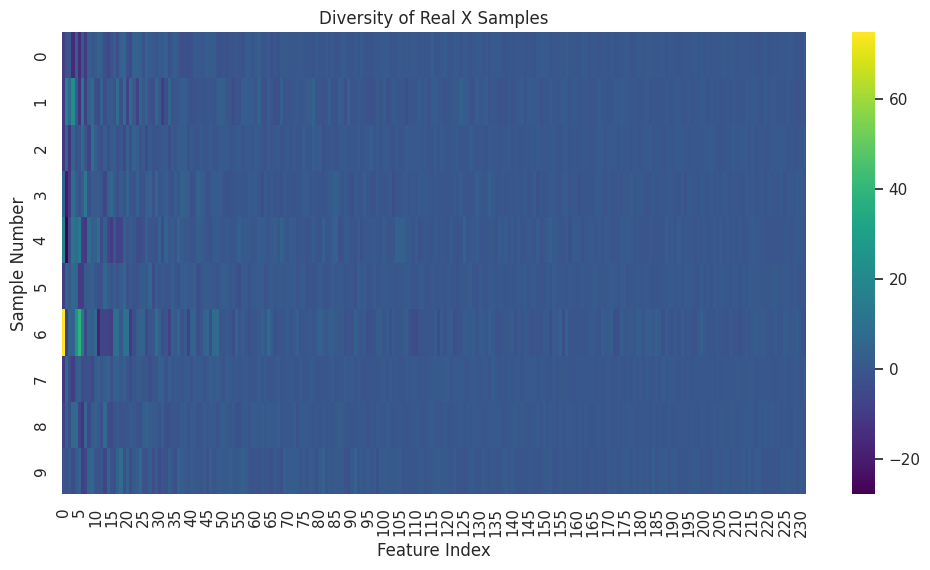

In [10]:
# Plot the first few dimensions to see diversity
plt.figure(figsize=(12, 6))
sns.heatmap(X_val.cpu().numpy()[:10], cmap="viridis", annot=False)
plt.xlabel("Feature Index")
plt.ylabel("Sample Number")
plt.title(f"Diversity of Real X Samples")
plt.show()

Save the model for use in other scripts

In [11]:
torch.save(model.state_dict(), 'cvae_model.pt')